In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

# %matplotlib widget

In [2]:
Lx = 96 # 384 # 768 # 1536
Ly = 2*Lx

m = 0.0

tau = Ly/Lx*np.exp( 1.0j*np.pi/3 )

In [3]:
def theta(z, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*tau)
        return coeff * s

    else:

        r = np.pi*1.0j/tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*tau)

        return coeff * s

In [4]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return -coeff * s

def th3(z, n=0):
    return theta(z, n)

def th4(z, n=0):
    return theta(z+0.5, n)

In [5]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

In [6]:
e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

In [7]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

In [8]:
def P2Alt(z):
    return np.sqrt( P(z)-e1 )
def P3Alt(z):
    return np.sqrt( P(z)-e2 )
def P4Alt(z):
    return np.sqrt( P(z)-e3 )

In [9]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

$$
\xi_P = r \, \psi_P \\
r = \sqrt{\frac{3\sqrt{3}}{2} a}
$$
And that:
$$
\eta(z) \equiv \sqrt{2\pi} \psi_1(z),
\quad
\bar\eta(z) \equiv i\sqrt{2\pi} \psi_2(\bar z),
$$
for which:
$$
\langle \eta(z) \eta(0)\rangle = 1/z,
\quad
\langle \bar\eta(\bar z) \bar\eta(0)\rangle = 1/{\bar z}.
$$

In [10]:
alat = 1.0/Lx
r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

## $\psi \psi$ correlator

In [11]:
xixi00 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3xixi00.dat")
xixi01 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3xixi01.dat")
xixi10 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3xixi10.dat")
xixi11 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3xixi11.dat")

$$
\langle \xi_{O,i} \xi_{P,j} \rangle
=
-{D^{-1}_{P,j}}^{O,k} \epsilon_{ki}
$$
or
$$
{D^{-1}_{P,j}}^{O,k} 
=
\langle \xi_{P,j} \xi_{O,i} \rangle
\epsilon^{ik}.
$$
Now that:
$$
\langle \xi_{P,j} \xi_{O,i} \rangle
=
r^2 
\langle \psi_{P,j} \psi_{O,i} \rangle
$$

In [12]:
tmp = np.array([[ [xx, yy, P3(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
etaeta_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

$$
(2\pi/r^2){D^{-1}_{P,0}}^{O,1} 
=
2\pi
\langle \psi_{P,0} \psi_{O,0} \rangle
\epsilon^{01}
=
\frac{1}{z}.
$$

In [13]:
tmpx = xixi01.T[0]
tmpy = xixi01.T[1]
tmpzr = xixi01.T[2]
tmpzi = xixi01.T[3]
res_ = []

for i in range(len(xixi01.T[0])):
    res_.append( [ tmpx[i]/Lx, tmpy[i]/Lx, 2.0*np.pi*(tmpzr[i]+1.0j*tmpzi[i])/r**2 ] )
etaeta = np.array(res_)

/tmp/ipykernel_46265/87881580.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.real(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_46265/87881580.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.real(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_46265/87881580.py:20: RuntimeWarning: invalid value encountered in log
  np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_46265/87881580.py:22: RuntimeWarning: i

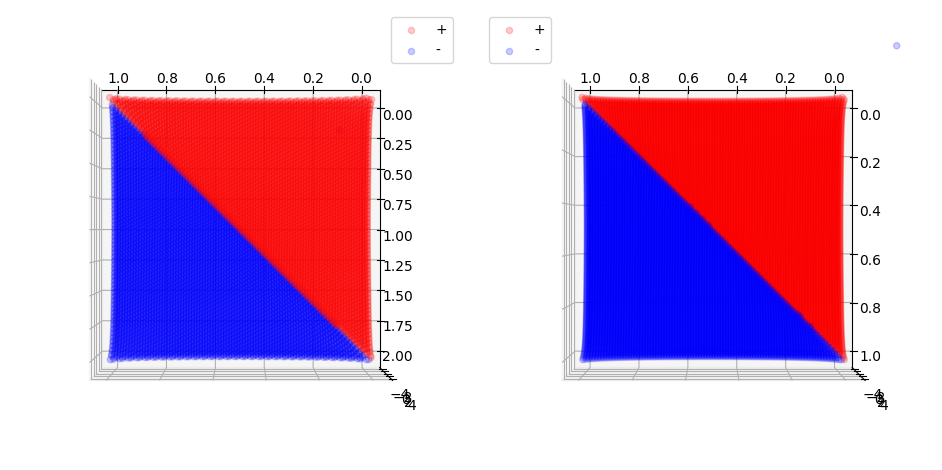

In [14]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.real(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.real(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

fig.tight_layout()

plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

/tmp/ipykernel_46265/1852000639.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_46265/1852000639.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
/tmp/ipykernel_46265/1852000639.py:20: RuntimeWarning: divide by zero encountered in log
  np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
/tmp/ipykernel_46265/1852000639.py:20: RuntimeW

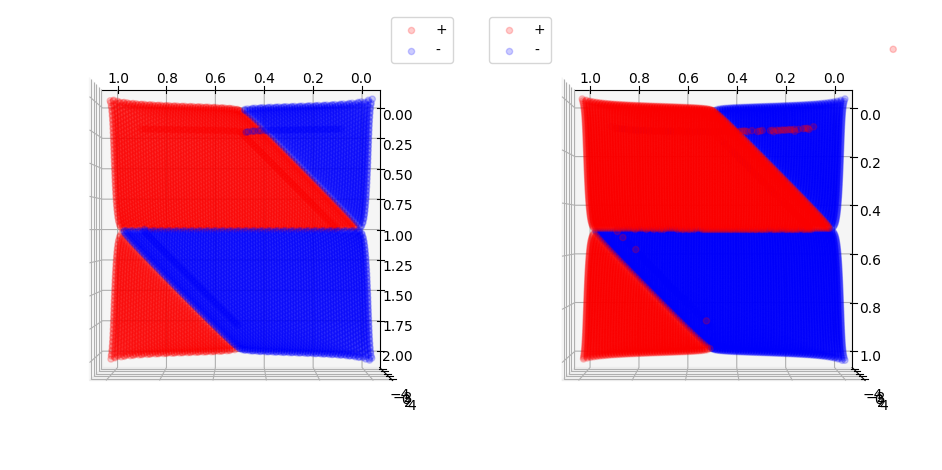

In [15]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(etaeta.T[0], etaeta.T[1], np.log(np.imag(etaeta.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta.T[0], etaeta.T[1], np.log(-np.imag(etaeta.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=90)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
           np.log(np.imag(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
ax.set_zlim( -5, 5)

ax.legend()

#################

fig.tight_layout()

plt.savefig('../plt/im_xixi_above.pdf',bbox_inches='tight')

/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_46265/2420629403.py:18: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1.0e2)


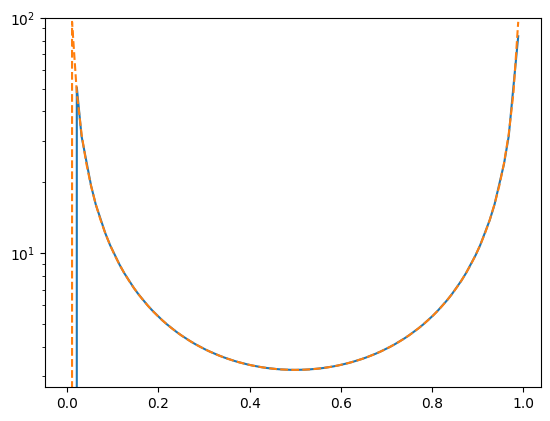

In [16]:
plt.close()

plt.plot( 
    etaeta.T[0][:int(Lx*2/3)], 
    etaeta.T[2][:int(Lx*2/3)],
    label="numeric"
        )

plt.plot(
    etaeta_analytic.T[0][:int(Lx)], 
    etaeta_analytic.T[2][:int(Lx)],
    label="analytic", 
    ls="dashed"
)

plt.yscale("log")

plt.ylim(0, 1.0e2)

plt.savefig('../plt/xixi_slice.pdf',bbox_inches='tight')

## $TT$ correlator

In [17]:
tt0000 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0000.dat")
tt0001 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0001.dat")
tt0002 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0002.dat")

tt0010 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0010.dat")
tt0011 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0011.dat")
tt0012 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0012.dat")

tt0020 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0020.dat")
tt0021 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0021.dat")
tt0022 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0022.dat")

#

tt0100 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0100.dat")
tt0101 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0101.dat")
tt0102 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0102.dat")

tt0110 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0110.dat")
tt0111 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0111.dat")
tt0112 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0112.dat")

tt0120 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0120.dat")
tt0121 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0121.dat")
tt0122 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0122.dat")

#

tt0200 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0200.dat")
tt0201 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0201.dat")
tt0202 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0202.dat")

tt0210 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0210.dat")
tt0211 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0211.dat")
tt0212 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0212.dat")

tt0220 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0220.dat")
tt0221 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0221.dat")
tt0222 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt0222.dat")

#

tt1000 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1000.dat")
tt1001 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1001.dat")
tt1002 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1002.dat")

tt1010 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1010.dat")
tt1011 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1011.dat")
tt1012 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1012.dat")

tt1020 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1020.dat")
tt1021 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1021.dat")
tt1022 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1022.dat")

#

tt1100 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1100.dat")
tt1101 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1101.dat")
tt1102 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1102.dat")

tt1110 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1110.dat")
tt1111 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1111.dat")
tt1112 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1112.dat")

tt1120 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1120.dat")
tt1121 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1121.dat")
tt1122 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1122.dat")

#

tt1200 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1200.dat")
tt1201 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1201.dat")
tt1202 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1202.dat")

tt1210 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1210.dat")
tt1211 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1211.dat")
tt1212 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1212.dat")

tt1220 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1220.dat")
tt1221 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1221.dat")
tt1222 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt1222.dat")

#

tt2000 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2000.dat")
tt2001 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2001.dat")
tt2002 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2002.dat")

tt2010 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2010.dat")
tt2011 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2011.dat")
tt2012 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2012.dat")

tt2020 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2020.dat")
tt2021 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2021.dat")
tt2022 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2022.dat")

#

tt2100 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2100.dat")
tt2101 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2101.dat")
tt2102 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2102.dat")

tt2110 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2110.dat")
tt2111 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2111.dat")
tt2112 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2112.dat")

tt2120 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2120.dat")
tt2121 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2121.dat")
tt2122 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2122.dat")

#

tt2200 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2200.dat")
tt2201 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2201.dat")
tt2202 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2202.dat")

tt2210 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2210.dat")
tt2211 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2211.dat")
tt2212 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2212.dat")

tt2220 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2220.dat")
tt2221 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2221.dat")
tt2222 = np.loadtxt("../data/m0.000000Lx96Ly192alat0.010000nu3tt2222.dat")

In [18]:
def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

In [19]:
def TTconn(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

In [20]:
tmp = np.array([[ [xx, yy, TTconn(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TTconn_analytic=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [21]:
tmp = tt0000 - 0.5*(tt0001+tt0002) - 0.5*(tt0100+tt0200) + 0.25*(tt0101+tt0102+tt0201+tt0202)
TxxTxx = (2.0*np.pi)**2/(9.0*alat**2) * 1.0/r**4 * np.array(tmp)

/tmp/ipykernel_46265/2722524989.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_46265/2722524989.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_46265/2722524989.py:23: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_46265/2722524989.py:25: RuntimeWarning: inv

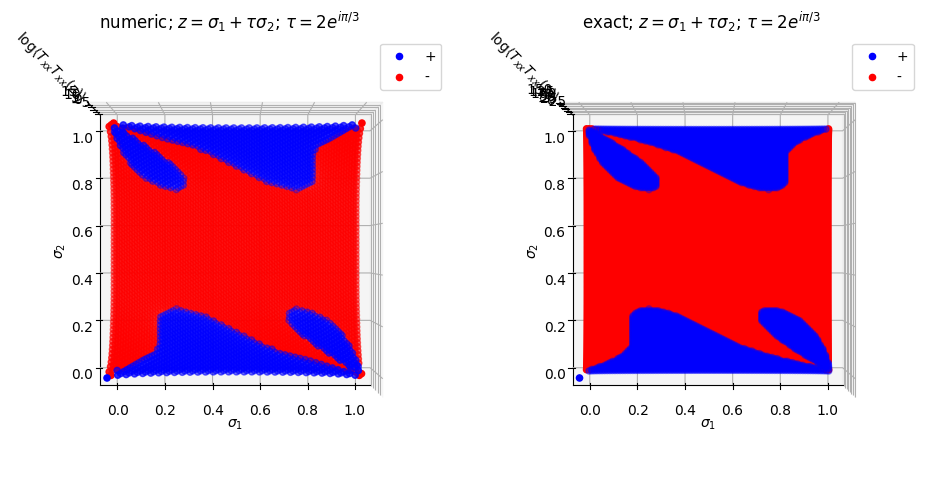

In [22]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxx_above.pdf',bbox_inches='tight')

/tmp/ipykernel_46265/2773931291.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_46265/2773931291.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_46265/2773931291.py:25: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_46265/2773931291.py:27: RuntimeWarning: inv

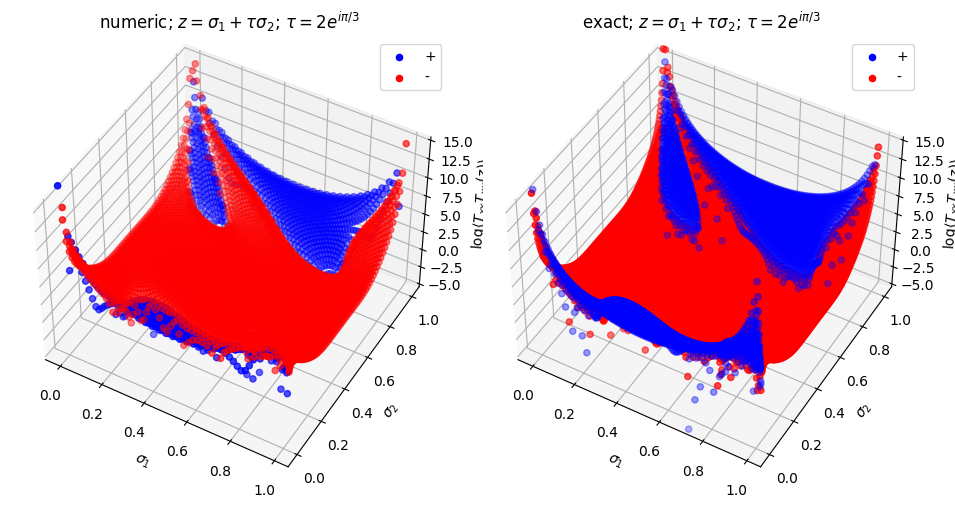

In [23]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxx.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxx.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxx_slant.pdf',bbox_inches='tight')

/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


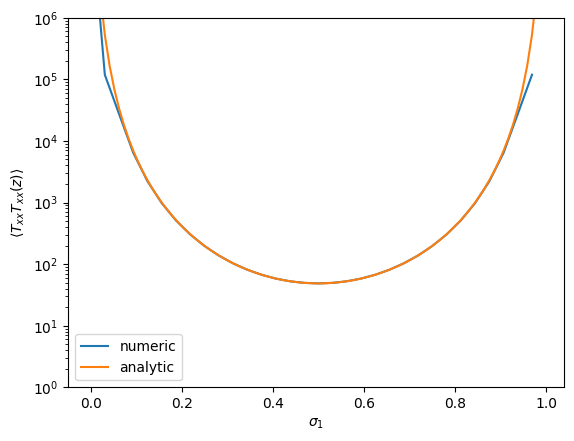

In [24]:
plt.close()

plt.plot( tt0000.T[0][:int(Lx/3)]/Lx, TxxTxx.T[6][:int(Lx/3)], label="numeric")
plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.real(TTconn_analytic.T[2][:Lx]), label="analytic")

plt.ylim(1.0,1.0e6)
plt.legend()

plt.xlabel("$\\sigma_1$")
plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

plt.yscale("log")
plt.savefig('../plt/TxxTxx_slice.pdf',bbox_inches='tight')

In [25]:
tmp1 = tt0022 - 0.5*(tt0020+tt0021) - 0.5*(tt0122+tt0222) + 0.25*(tt0120+tt0121+tt0220+tt0221)
tmp2 = tt0011 - 0.5*(tt0012+tt0010) - 0.5*(tt0111+tt0211) + 0.25*(tt0112+tt0110+tt0212+tt0210)
TxxTxy = (2.0*np.pi)**2/(18.0*alat**2) * 1.0/r**4 * (np.array(tmp1) - np.array(tmp2))

In [ ]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxy_above.pdf',bbox_inches='tight')

/tmp/ipykernel_46265/2788606806.py:9: RuntimeWarning: divide by zero encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_46265/2788606806.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
/tmp/ipykernel_46265/2788606806.py:10: RuntimeWarning: divide by zero encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_46265/2788606806.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")
/tmp/ipykernel_46265/2788606806.py:24: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/home/nobu68/.local/lib/python3.10/site-packages/matplotlib/collections.p

In [ ]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(TxxTxy.T[6]), c='b', marker='o', label="+")
ax.scatter(tt0000.T[0]/Lx, tt0000.T[1]/Ly, np.log(-TxxTxy.T[6]), c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("numeric; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=45., azim=-60)

ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="+")
ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="-")

ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")
ax.set_zlim( -5, 15)

#################

fig.tight_layout()
plt.savefig('../plt/TxxTxy_slant.pdf',bbox_inches='tight')

In [ ]:
# plt.close()

# plt.plot( tt0000.T[0][:int(Lx/3)]/Lx, TxxTxy.T[6][:int(Lx/3)], label="numeric")
# plt.plot( TTconn_analytic.T[0][:Lx], 2.0 * np.imag(TTconn_analytic.T[2][:Lx]), label="analytic")

# # plt.ylim(1.0,1.0e6)
# plt.legend()

# plt.xlabel("$\\sigma_1$")
# plt.ylabel("$\\langle T_{xx}T_{xx}(z) \\rangle$")

# plt.yscale("log")